 ### Bayesian Statistics, Course Project 
# Kaggle challenge on particle physics
# Logistic regression with JAGS and OSS undersampling
### Vanilla implementation


### Adrián Fernández Cid, Aitor Lucas Castellano, Marcos Moreno Blanco & Noel Rabella Gras
### 28-06-2021

***
###### LaTeX macros
$\def\prob{P}$
$\def\argmax{\operatorname{arg\,max}}$
$\def\argmin{\operatorname{arg\,min}}$
$\def\borel{\operatorname{Borel}}$
$\def\cE{\cal E}$
$\def\cP{\cal P}$
$\def\R{\mathbb{R}}$ 
$\def\N{\mathbb{N}}$
$\def\Z{\mathbb{Z}}$
$\def\Ee{\operatorname{E}}$
$\def\va{\text{v.a.}}$
$\def\var{\operatorname{var}}$
$\def\Var{\operatorname{Var}}$
$\def\cov{\operatorname{cov}}$
$\def\cor{\operatorname{cor}}$
$\def\binomdist{\operatorname{Binom}}$
$\def\berndist{\operatorname{Ber}}$
$\def\betabinomdist{\operatorname{Beta-Binom}}$
$\def\betadist{\operatorname{Beta}}$
$\def\cauchydist{\operatorname{Cauchy}}$
$\def\dexpdist{\operatorname{DExp}}$
$\def\expdist{\operatorname{Exp}}$
$\def\fdist{\operatorname{F}}$
$\def\gammadist{\operatorname{Gamma}}$
$\def\geomdist{\operatorname{Geom}}$
$\def\halfcauchydist{\operatorname{Cauchy}^{+}}$
$\def\hyperdist{\operatorname{Hypergeom}}$
$\def\hypergeomdist{\operatorname{Hypergeom}}$
$\DeclareMathOperator{\invgammadist}{IG}$
$\def\laplacedist{\operatorname{Laplace}}$
$\DeclareMathOperator{\multinomialdist}{Multinomial}$
$\DeclareMathOperator{\multinomdist}{Multinom}$
$\def\normaldist{\operatorname{N}}$
$\def\poissondist{\operatorname{Poisson}}$
$\def\tdist{\operatorname{t}}$
$\def\unifdist{\operatorname{Unif}}$
$\def\xbar{\kern1.3pt\overline{\kern-1.3pt x}}$
$\def\Xbar{\kern1.3pt\overline{\kern-1.3pt X}}$
$\def\yhat{\kern1.3pt\hat{\kern-1.3pt y}}$
$\def\betahat{\kern1.3pt\hat{\kern-1.3pt \beta}}$
$\DeclareMathOperator{\indica}{\mathbb{1}}$
$\def\CondTo{\mathbin{|\mskip0.5mu}}$
$\def\eqdef{\stackrel{\text{def}}{\mskip3mu=\mskip3mu}}$
***

The following code reproduces the treatment in **CERN-RandomSamples-Logistic-JAGS.ipynb**, but with our Recurrent Targetted Removal method for undersampling (implemented here with One-Sided-Selection) instead of the random one and excluding the horseshoe prior part due to its null contribution to performance. We refer to the said notebook for further details.

## Outline
### 1. Data exploration and preprocessing   
### 2. Vanilla logistic regression with JAGS
#### 2.1. Modelling
#### 2.2. Evaluation 
### 3. Conclusion

## 1. Data exploration and preprocessing

We have a tabular dataset with information on particle collisions recorded at the LHCb experiment at CERN, and the objective is to identify the presence of a specific process: **the decomposition of $B_0$ into $K^0$**. We therefore have a binary classification problem, in which the focus is placed on the pòsitive signal. This last point suggests we keep an eye on recall (also known as sensitivity) to maximise true postives.

Since the meaning of the predictors is not obvious, we include their description here:

**B_FDCHI2_OWNPV**: Flight distance of the B meson with respect to the primary vertex (point of proton-proton collision).

**B_IPCHI2_OWNPV**: Impact parameter. Shortest distance between the B meson trajectory and the primary vertex.

**B_PT**: B meson transverse momentum

**PIMINUS** & **KPLUS PSEUDORAPIDITY**: Angle of the piminus and Kplus particles with respect to the beam axis.

**KPLUS** & **PIMINUS P**: Kplus and piminus momentum.

**KST_892_0_COSTHETAH**: K* helicity angle. Angle formed bewteen one of the particle products of K* (piminus or Kplus) and the B meson in the reference frame of the K* (rest frame)
GAMMA_PT: photon transverse momentum.

**KST_892_0_IP_OWNPV**: Impact parameter of K*, which corresponds to the shortest distance between the K* trajectory and the primary vertex.

**B_OWNPV_CHI2**: Chi2 test of the primary vertex distribution.

**KPLUS** & **PIMINUS IP_OWNPV**: Shortest distance between the Kplus or the piminus trajectory and the primary vertex.

**B_DIRA_OWNPV**: Corresponds to the cosine of the angle formed by the momentum of the B meson and the vector formed between the initial (primary vertex) and final position (decay vertex) of the B meson.

The data, published code and other details of the challenge are available at:
https://www.kaggle.com/c/cernsignal/overview.



In [1]:
# load required packages for the whole notebook
require(mcsm)
require(bayesplot)
require(dplyr)
#install.packages("Epi",dependencies=TRUE,repos="https://cloud.r-project.org")
require(Epi)
#install.packages("corrplot",dependencies=TRUE,repos="https://cloud.r-project.org")
require(corrplot)
#install.packages("R2jags",dependencies=TRUE,repos="https://cloud.r-project.org")
require(R2jags)
#install.packages("pROC",dependencies=TRUE,repos="https://cloud.r-project.org")
require(pROC)
#install.packages("unbalanced",dependencies=TRUE,repos="https://cloud.r-project.org")
require(unbalanced)

Loading required package: mcsm

Loading required package: MASS

Loading required package: coda

Loading required package: bayesplot

This is bayesplot version 1.8.0

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting

Loading required package: dplyr


Attaching package: ‘dplyr’


The following object is masked from ‘package:MASS’:

    select


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Epi

Loading required package: corrplot

corrplot 0.87 loaded

Loading required package: R2jags

Loading required package: rjags

Linked to JAGS 4.3.0

Loaded modules: basemod,bugs


Attaching package: ‘R2jags’


The following object is masked from ‘package:coda’:

    traceplot


Loadin

Load labelled dataset (we will only use this):

In [2]:
train <- read.csv("data/train.csv")
names(train)
str(train)

[1] "Id"                  "B_OWNPV_CHI2"        "B_IPCHI2_OWNPV"     
 [4] "B_FDCHI2_OWNPV"      "B_DIRA_OWNPV"        "B_PT"               
 [7] "Kst_892_0_IP_OWNPV"  "Kst_892_0_cosThetaH" "Kplus_IP_OWNPV"     
[10] "Kplus_P"             "piminus_IP_OWNPV"    "piminus_P"          
[13] "gamma_PT"            "piminus_ETA"         "Kplus_ETA"          
[16] "BUTTER"              "signal"

'data.frame':	212662 obs. of  17 variables:
 $ Id                 : int  0 1 2 3 4 5 6 7 8 9 ...
 $ B_OWNPV_CHI2       : num  28.9 34.2 36.1 14.3 60.5 ...
 $ B_IPCHI2_OWNPV     : num  2.6625 0.0927 2.4424 6.3376 7.6328 ...
 $ B_FDCHI2_OWNPV     : num  2925 347 239 227 107 ...
 $ B_DIRA_OWNPV       : num  1 1 1 1 1 ...
 $ B_PT               : num  19086 6631 7741 6740 5556 ...
 $ Kst_892_0_IP_OWNPV : num  0.569 0.249 0.222 0.347 0.204 ...
 $ Kst_892_0_cosThetaH: num  -0.576 -0.616 0.249 0.592 0.656 ...
 $ Kplus_IP_OWNPV     : num  0.582 0.278 0.217 0.307 0.197 ...
 $ Kplus_P            : num  66851 39274 27757 10593 11801 ...
 $ piminus_IP_OWNPV   : num  0.638 0.149 0.25 0.401 0.223 ...
 $ piminus_P          : num  14298 11553 24081 11344 25941 ...
 $ gamma_PT           : num  7941 3905 4739 3309 4026 ...
 $ piminus_ETA        : num  2.63 3.29 3.43 2.29 3.29 ...
 $ Kplus_ETA          : num  2.68 3.09 3.12 2.2 3.28 ...
 $ BUTTER             : num  0.551 0.543 0.866 -0.443 -0.447 ...
 $ s

There are no NA (not available) values:

In [3]:
dim(train)
sum(is.na(train))
train=na.omit(train)
dim(train)
sum(is.na(train))

[1] 212662     17

[1] 0

[1] 212662     17

[1] 0

Remove **Id** (just an index) and **BUTTER** (an irrelevant column with butter consumption in Switzerland, purposely placed as a test). All other columns are numeric, so no need to factor any of them nor for a subsequent one-hot encoding.

In [4]:
data <- select(train, -Id
               , -BUTTER
              )
# rename "signal" column to fit the rest of the code
names(data)[names(data) == 'signal'] <- 'Response'
str(data)

'data.frame':	212662 obs. of  15 variables:
 $ B_OWNPV_CHI2       : num  28.9 34.2 36.1 14.3 60.5 ...
 $ B_IPCHI2_OWNPV     : num  2.6625 0.0927 2.4424 6.3376 7.6328 ...
 $ B_FDCHI2_OWNPV     : num  2925 347 239 227 107 ...
 $ B_DIRA_OWNPV       : num  1 1 1 1 1 ...
 $ B_PT               : num  19086 6631 7741 6740 5556 ...
 $ Kst_892_0_IP_OWNPV : num  0.569 0.249 0.222 0.347 0.204 ...
 $ Kst_892_0_cosThetaH: num  -0.576 -0.616 0.249 0.592 0.656 ...
 $ Kplus_IP_OWNPV     : num  0.582 0.278 0.217 0.307 0.197 ...
 $ Kplus_P            : num  66851 39274 27757 10593 11801 ...
 $ piminus_IP_OWNPV   : num  0.638 0.149 0.25 0.401 0.223 ...
 $ piminus_P          : num  14298 11553 24081 11344 25941 ...
 $ gamma_PT           : num  7941 3905 4739 3309 4026 ...
 $ piminus_ETA        : num  2.63 3.29 3.43 2.29 3.29 ...
 $ Kplus_ETA          : num  2.68 3.09 3.12 2.2 3.28 ...
 $ Response           : num  1 1 1 0 0 0 1 0 0 0 ...


As we discussed in **CERN-RandomSamples-Logistic-JAGS.ipynb**, the variable **B_DIRA_OWNPV** seems to have little variability and therefore contain little information. However, we won't remove it for the sake of comparison.

In [5]:
summary(data$B_DIRA_OWNPV)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.9995  1.0000  1.0000  1.0000  1.0000  1.0000 

Note the signal (presence of the process of interest $\equiv$ 1) is sparse:

In [6]:
n<-length(data$Response)
n
n1<-sum(data$Response)
n1
f<-n1/n
round(f,3)


[1] 212662

[1] 71030

[1] 0.334

This would have to be dealt with by giving a larger weight to the positive class, some resampling strategy (oversampling or undersampling techniques) to balance the data, or by a prior suitable for sparse signals such as the horseshoe. 

In the present case, as in the second assignment, JAGS (being an MCMC code) takes too long for the whole dataset, since it has to reevaluate the linear predictor $\eta$ *for all samples at every iteration*. This simplifies the choice: it means we have to undersample the original dataset. This bears the disadvantage of reducing the information available to the model (albeit information we could not have realistically used in its entirety anyway), and the question now is how to make the subsample maximally informative.

In this regard, the most obvious possibility is to randomly pick a perfectly balanced subset of data, effectively removing the imbalance problem: this is what we did in the second assignment and in **CERN-RandomSamples-Logistic-JAGS.ipynb**, but in this notebook we will try a more sophisticated strategy in order to select maximally informative samples: our Recurrent Targetted Removal (RDR) algorithm. As explained in the report, the RTR alternates between targetted removal (in this case, with One-Sided Selection) and random removal of a given percentage of samples, in an effort to maximise the number of samples selected by the more sophisticated strategy.

For the sake of rigour, we take as large a subsample as we reasonably can (2000 samples takes us about 40 min to process with JAGS -which we do a total of 3 times-, so we settle for that number) and repeat the process another 2 times for consistency checks (all with a fixed seed, for reproducibility).

To render the process more agile, we define a function that does the subsampling and one for the random subsampling sub-routine. The latter is:

In [7]:
subsample.class<-function(class, sample.size, seed=NULL){
    if (!is.null(seed)){set.seed(seed)}  # for reproducibility
    # positive subsamples
    row.idx <- sample(seq_len(nrow(class)),size = sample.size) # Randomly (uniform dist) identifies the rows equal to sample size from  all the rows of data and stores the row number in row.idx
    sample <- class[row.idx,] #creates the training dataset with row numbers stored in train.ind
    return(sample)
    }

And the RTR function is defined below. The input parameters are:

**data.** The dataset to be undersampled (a data frame).

**ref.size.** The reference size for the resubting subsample. Since the real final size varies depending on the parameter configuration, we default it to 2500 samples to make sure we get at least 2000.

**seed.** Random seed, for reproducibility.

**min.red** Lower bound on targetted removal reduction at each step, so that the code switches to random removal when it barely changes the current dataset.

**rand.frac.** Fraction of samples to preserve for each random removal.

**verbose.** Takes values 0, 1 or 2 in order of increasing verbosity.

**range.** Range of signal fraction to be imposed to targetted removal. Maniputaltion of this parameter and of min.red should be done with care, as some combinations will get the code stuck in the targetted removal loop.

**halt.cond.** To prevent the above problem, this number defines the maximum number of targetted removals of the first global iteration before halting execution and asking for a different combination of min.pred and range.

Note that, as mentioned in the report, random removal is performed only on the negative class in order to maximise the number of positive samples that are judiciously chosen.

In [8]:
RTR<-function(data, ref.size=2500, seed=4, min.red=500, rand.frac=0.7, verbose=1, range=c(0.4,0.6), halt.cond=30){
    if (!is.null(seed)){set.seed(seed)}  # for reproducibility
    X <- select(data, -Response)
    Y <- data$Response
    sample.size<-length(Y)
    signal.fraction<-sum(Y)/sample.size
    #initialise counters
    count.oss<-0
    count.rand<-0
    tot.count<-0
    total.targetted.removals<-0
    total.random.removals<-0
    # reversed = TRUE when signal is inverted (0 to 1 and viceversa)
    reversed<-FALSE
    #halt flag, in case code gets stuck
    halt<-FALSE
    #initialise condition of outer while loop (containing targetted and random removal)
    cond1<-sample.size > ref.size | signal.fraction<range[1] | signal.fraction>range[2]
    #outtter (global) while loop
    while (cond1){
        #initialise condition of inner while loop (containing recursive targetted removal)
        reduction<-min.red+1
        cond2<-(sample.size > ref.size & reduction > min.red) | (signal.fraction<range[1] | signal.fraction>range[2])
        while (cond2){
            #subsample current data with chosen criterion
            subsample.oss<-ubOSS(X, Y, verbose = FALSE)
            #update X and Y and some indicators 
            X<-subsample.oss$X
            Y<-subsample.oss$Y
            reduction<-sample.size-length(Y)
            total.targetted.removals<-total.targetted.removals+reduction
            sample.size<-length(Y)
            #compute signal fraction according to whether ir is reversed or not
            if (!reversed){signal.fraction<-sum(Y)/sample.size}
            else {signal.fraction<-1-sum(Y)/sample.size}
            count.oss<-count.oss+1
            # if inputted extra verbosity (2), print info on the targetted subsampling
            if (verbose==2){
            cat("\nTotal count =", tot.count,"\nOSS count =", count.oss,
                        "\nRand count =", count.rand,"\nSample size =",sample.size, "\nReduction =", reduction, 
                        "\nSignal fraction =", signal.fraction,"\n")
            flush.console() #so that print appears in real time
            }
            if (count.oss>halt.cond & count.rand==0) {
                cat("\nStuck in targetted removal while loop: please change inputs 'min.red' and/or 'range'\n")
                flush.console()
                #halt flag, to break also from outter loop
                halt<-TRUE
                break
            }
            #update condition of inner while loop
            cond2<-(sample.size > ref.size & reduction > min.red) | (signal.fraction<range[1] | signal.fraction>range[2])

        }
        #break from outter loop to halt algorithm if got stuck in inner loop
        if (halt) {
            break
        }
        #if signal was not already reversed (1st iteration), reverse it and change the 
        #state of the flag accordingly
        if (!reversed){
            Y<-Y+1
            Y[Y==2]<-0
            reversed<-TRUE
        }
        #if desired sample.size not met after targetted removal, do random removal
        if (sample.size>ref.size){
            Response<-Y
            df<-cbind(X,Response)
            #retrieve positives and negatives (with reversed signal)
            positives=subset(df, df$Response==0)
            negatives=subset(df, df$Response==1)
            neg.size<-dim(negatives)[1]
            #randomly remove a percentage of negative instances
            sub.neg<-subsample.class(negatives, round(rand.frac*neg.size)
                                     #, seed
                                    )
            df<-rbind(positives, sub.neg)
            #update X, Y and some indicators
            X<-select(df, -Response)
            Y<-df$Response
            reduction<-sample.size-length(Y)
            total.random.removals<-total.random.removals+reduction
            sample.size<-length(Y)
            signal.fraction<-1-sum(Y)/sample.size
            count.rand<-count.rand+1 
            }
        tot.count<-tot.count+1
        #if verbose input is default (1) or more, print some useful info
        if (verbose>0){
            cat("\nTotal count =", tot.count,"\nOSS count =", count.oss,"\nRand count =", count.rand,"\nSample size =", 
                                           sample.size,"\nSignal fraction =", signal.fraction, "\n")
            flush.console() #so that print is shown in real time
        }
        #update condition of outter while loop
        cond1<-sample.size > ref.size | signal.fraction<range[1] | signal.fraction>range[2]
    }
    #undo the signal inversion
    Y<-Y+1
    Y[Y==2]<-0
    sum(Y)/length(Y)
    #obtain resulting train and test subsamples, and return them along with total numbers 
    #of random and targetted removals
    #note the undersampling process conserves the original row indices, so we 
    #can use them to obtain the test subset as the complementary of the train one
    Response<-Y
    train.sub<-cbind(X, Response)
    row.idx<-as.integer(row.names(train.sub))
    test.sub<-data[-row.idx,]
    return(list("train"=train.sub, "test"=test.sub, "targetted"=total.targetted.removals,
           "random"=total.random.removals))

}

Now, we produce our three subsamples (this takes us 15-20 min each time). For speed, one can also load them from the previously saved files (see below).

In [9]:
rand.frac<-0.7
range<-c(0.40, 0.60)

In [10]:
seed<-4
start.time <- Sys.time()
subsample.01<-RTR(data, rand.frac=rand.frac, range=range, seed = seed)
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken


Total count = 1 
OSS count = 14 
Rand count = 1 
Sample size = 108931 
Signal fraction = 0.6520642 

Total count = 2 
OSS count = 26 
Rand count = 2 
Sample size = 62652 
Signal fraction = 0.5765339 

Total count = 3 
OSS count = 32 
Rand count = 3 
Sample size = 46698 
Signal fraction = 0.6022956 

Total count = 4 
OSS count = 38 
Rand count = 4 
Sample size = 34407 
Signal fraction = 0.6221699 

Total count = 5 
OSS count = 43 
Rand count = 5 
Sample size = 25391 
Signal fraction = 0.6416053 

Total count = 6 
OSS count = 47 
Rand count = 6 
Sample size = 19241 
Signal fraction = 0.6689361 

Total count = 7 
OSS count = 54 
Rand count = 7 
Sample size = 13964 
Signal fraction = 0.6806789 

Total count = 8 
OSS count = 69 
Rand count = 8 
Sample size = 9797 
Signal fraction = 0.6814331 

Total count = 9 
OSS count = 102 
Rand count = 9 
Sample size = 6863 
Signal fraction = 0.6816261 

Total count = 10 
OSS count = 131 
Rand count = 10 
Sample size = 4806 
Signal fraction = 0.6816479

Time difference of 16.9597 mins

In [11]:
seed<-44
start.time <- Sys.time()
subsample.02<-RTR(data, rand.frac=rand.frac, range=range, seed = seed)
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken


Total count = 1 
OSS count = 15 
Rand count = 1 
Sample size = 108597 
Signal fraction = 0.6540696 

Total count = 2 
OSS count = 27 
Rand count = 2 
Sample size = 61783 
Signal fraction = 0.5743651 

Total count = 3 
OSS count = 33 
Rand count = 3 
Sample size = 46235 
Signal fraction = 0.6018601 

Total count = 4 
OSS count = 39 
Rand count = 4 
Sample size = 34369 
Signal fraction = 0.6250691 

Total count = 5 
OSS count = 44 
Rand count = 5 
Sample size = 25958 
Signal fraction = 0.6525156 

Total count = 6 
OSS count = 49 
Rand count = 6 
Sample size = 19552 
Signal fraction = 0.6770663 

Total count = 7 
OSS count = 59 
Rand count = 7 
Sample size = 13848 
Signal fraction = 0.6808203 

Total count = 8 
OSS count = 92 
Rand count = 8 
Sample size = 9717 
Signal fraction = 0.681589 

Total count = 9 
OSS count = 116 
Rand count = 9 
Sample size = 6802 
Signal fraction = 0.6815642 

Total count = 10 
OSS count = 148 
Rand count = 10 
Sample size = 4759 
Signal fraction = 0.6814457 

Time difference of 17.70996 mins

In [12]:
seed<-444
start.time <- Sys.time()
subsample.03<-RTR(data, rand.frac=rand.frac, range=range, seed = seed)
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken


Total count = 1 
OSS count = 15 
Rand count = 1 
Sample size = 108640 
Signal fraction = 0.6538108 

Total count = 2 
OSS count = 27 
Rand count = 2 
Sample size = 62236 
Signal fraction = 0.5769812 

Total count = 3 
OSS count = 33 
Rand count = 3 
Sample size = 46394 
Signal fraction = 0.6027719 

Total count = 4 
OSS count = 38 
Rand count = 4 
Sample size = 34806 
Signal fraction = 0.6293742 

Total count = 5 
OSS count = 43 
Rand count = 5 
Sample size = 26010 
Signal fraction = 0.6528258 

Total count = 6 
OSS count = 48 
Rand count = 6 
Sample size = 19556 
Signal fraction = 0.6767744 

Total count = 7 
OSS count = 59 
Rand count = 7 
Sample size = 13853 
Signal fraction = 0.6805746 

Total count = 8 
OSS count = 76 
Rand count = 8 
Sample size = 9719 
Signal fraction = 0.6812429 

Total count = 9 
OSS count = 103 
Rand count = 9 
Sample size = 6813 
Signal fraction = 0.681638 

Total count = 10 
OSS count = 122 
Rand count = 10 
Sample size = 4770 
Signal fraction = 0.681761 


Time difference of 16.64641 mins

In [13]:
subsample.01$targetted
subsample.01$random
train.01<-subsample.01$train
test.01<-subsample.01$test

subsample.02$targetted
subsample.02$random
train.02<-subsample.02$train
test.02<-subsample.02$test

subsample.03$targetted
subsample.03$random
train.03<-subsample.03$train
test.03<-subsample.03$test

[1] 157395

[1] 53394

[1] 157881

[1] 52924

[1] 157825

[1] 52985

Note that roughly 3 times as many samples as those removed randomly have been removed with the targetting method: as we comment on in the report, this is in principle much better than just performing targetted removal once (as we do in **CERN-MinTargSamples-Logistic-JAGS.ipynb**) or a first series of times (that still leaves a dataset of around 120 000 samples) and then simply randomly removing excess samples. Also, the final proportion of the positive signal is a bit over the negative one, but such imbalance is less than at the beginning and, most importantly, it favours the positive signal, which is the one we are interested in.

Since producing the subsamples takes some time, we write the train indices to csv files. Note that there are two sets of indices for the OSS RTR in *data/*; since we have no direct control over the final size, we first produced three samples that had a bit over 2000 points and thus took us 1h each to process with JAGS. We have decided to keepp those files, but use here the set of smaller subsamples computed above (marked by the "_small.csv" ending, as below) in case you want to rerun them.

In [14]:
row.idx<-as.integer(row.names(train.01))
write.csv(row.idx#matrix(vector, nrow=1)
          , file ="data/oss_train_idx_01_small.csv", row.names=FALSE)

row.idx<-as.integer(row.names(train.02))
write.csv(row.idx#matrix(vector, nrow=1)
          , file ="data/oss_train_idx_02_small.csv", row.names=FALSE)

row.idx<-as.integer(row.names(train.03))
write.csv(row.idx#matrix(vector, nrow=1)
          , file ="data/oss_train_idx_03_small.csv", row.names=FALSE)

And we can load the saved train indices and define train and test subsamples as follows (you can directly do this if you prefer to avoid recomputing them):

In [192]:
row.idx<-read.csv(file="data/oss_train_idx_01_small.csv")
train.01<-data[row.idx$x,]
test.01<-data[-row.idx$x,]

row.idx<-read.csv(file="data/oss_train_idx_02_small.csv")
train.02<-data[row.idx$x,]
test.02<-data[-row.idx$x,]

row.idx<-read.csv(file="data/oss_train_idx_03_small.csv")
train.03<-data[row.idx$x,]
test.03<-data[-row.idx$x,]

str(train.01)

Format train subsamples for JAGS:

In [15]:
# Convert factors to one-hot indicators
x.01<-model.matrix(Response~.,train.01)[,-1] #[,-1] to remove intercept intrduced by model.matrix
y.01<-train.01$Response
#check x.01 is indeed ohe'd (eg see "Vehicle_Age")
#head(x.01)
x.02<-model.matrix(Response~.,train.02)[,-1] 
y.02<-train.02$Response

x.03<-model.matrix(Response~.,train.03)[,-1] 
y.03<-train.03$Response

As we have seen in class, non-standardised data yields instability, so let us standardise x. Again, for agility, we define a function to do it:

In [17]:
standardise<-function(x){
    #compute means of every column (2 for columns, 1 for rows)) of X
    xm<-apply(x,2,mean)
    # center each column by substracting its mean
    xc<-sweep(x,2,xm,"-")
    # get standard dev of columns of xc
    xs<-apply(xc,2,sd)
    # standardise xc by dividing each column by its sd
    x0<-sweep(xc,2,xs,"/")
    return(x0)}

In [18]:
x0.01<-standardise(x.01)
x0.02<-standardise(x.02)
x0.03<-standardise(x.03)
#head(x0.01)
# check that all vertical means of x0.01 are indeed 0
round(max(abs(apply(x0.01,2,mean))),6) 
# check that indeed sd's of columns of x0.01 are 1
round(apply(x0.01,2,sd), 5)

[1] 0

B_OWNPV_CHI2      B_IPCHI2_OWNPV      B_FDCHI2_OWNPV        B_DIRA_OWNPV 
                  1                   1                   1                   1 
               B_PT  Kst_892_0_IP_OWNPV Kst_892_0_cosThetaH      Kplus_IP_OWNPV 
                  1                   1                   1                   1 
            Kplus_P    piminus_IP_OWNPV           piminus_P            gamma_PT 
                  1                   1                   1                   1 
        piminus_ETA           Kplus_ETA 
                  1                   1

The condition number $\kappa$ is indeed much smaller after standardisation, meaning a more stable regression:

In [19]:
#have to take the intercept into account as well for the condition number
x1.01<-cbind(rep(1,n),x.01)
x01.01<-cbind(rep(1,n),x0.01)
round(kappa(x1.01),1)
round(kappa(x01.01),1)

[1] 1497740755

[1] 13.5

Another thing we should do is check the correlation between predictors (i.e. colinearity, which is invariant under centering and scaling). One should do it for all the available data, so we obtain a suitable dataframe:

In [20]:
colnames(data)[15]

[1] "Response"

In [21]:
x.corr<-model.matrix(Response~.,data)[,-1]
cn<-colnames(x.corr)
x.corr<-cbind(x.corr, data[, 15]) # add Response column
colnames(x.corr)<-c(cn, "Response")
str(x.corr)
#head(x.corr)

 num [1:212662, 1:15] 28.9 34.2 36.1 14.3 60.5 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:212662] "1" "2" "3" "4" ...
  ..$ : chr [1:15] "B_OWNPV_CHI2" "B_IPCHI2_OWNPV" "B_FDCHI2_OWNPV" "B_DIRA_OWNPV" ...


Note we have included the response in x.corr. this will give us a first hint of which predictors are most important for the classification. The plot of the correlation matrix is:

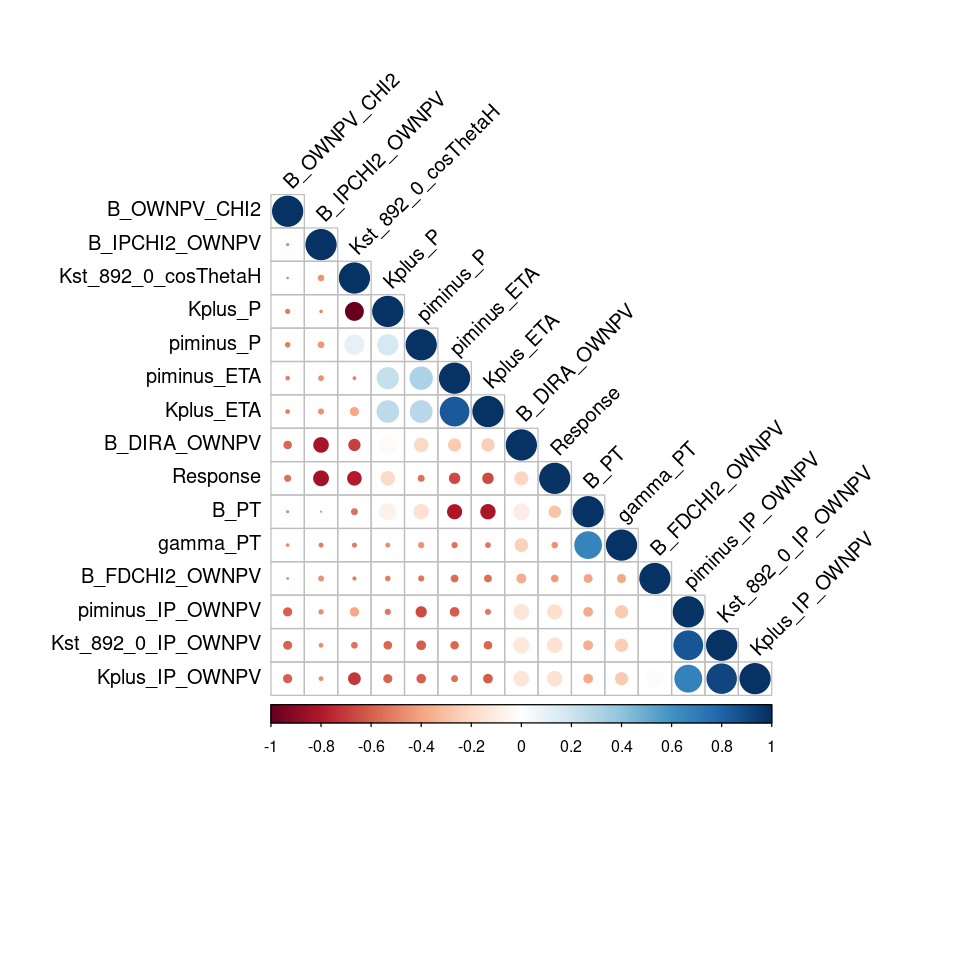

In [22]:
options(repr.plot.width=8,repr.plot.height=8)
corrplot(cor(x.corr), type="lower", order="hclust", tl.col="black", tl.srt=45)

Looks like we have remarkable positive correlation in the pairs **piminus_ETA/Kplus_ETA**, **B_PT/gamma_PT** and the triplet **piminus_IP_OWNPV/Kst_892_0_IP_OWNPV/Kplus_IP_OWNPV**, and negative correlation in the pairs **Kplus_P/Kst_892_0_cosThetaH**, **Kplus_IP_OWNPV/Kst_892_0_cosThetaH**, **B_DIRA_OWNPV/Kst_892_0_cosThetaH**, **B_DIRA_OWNPV/B_IPCHI2_OWNPV**, **B_PT/piminus_ETA** and **B_PT/Kplus_ETA**.

Regarding the response, it has strong negative correlation with **Kst_892_0_cosThetaH** and with **B_IPCHI2_OWNPV**.

## 2. Vanilla logistic regression with JAGS

### 2.1. Modelling

As in Week 12's *GLM.01.Logistic.Challenger.ipynb*, we have centered Gaussian priors for the logistic coefficients $\beta_i$, all with $\sigma = 10$, thus precision $\tau = 0.01$ (the same we use in the horseshoe case for $\beta_0$, for the sake of comparison). The likelihood of the logistic regression is, as seen in the mentioned notebook, a Bernoulli distribution with probability $p_i$ given by the logistic function. More graphically:

$$
    \begin{array}{lclcll}
        y_{i}           &\sim    &Bern(p_i),&&&1\leq i\leq n,\\[0.2cm]
         p_i &=      &\operatorname{Logistic}(\eta_i) =\dfrac{\exp(\eta_i)}{1+\exp(\eta_i)},&&&1\leq i\leq n,\\[0.2cm]
        \eta_{i}         &=     &\beta_{0}+x_{i\,\cdot\,}\cdot \beta,\mskip45mu  &&&1\leq i\leq n,\\[0.2cm]
        \beta_{j}        &\sim   &\normaldist(0,1.0E01), &&0\leq j\leq p,\\[0.2cm]
    \end{array}
$$


Define the JAGS model (very similar to what we did with the Challenger data):

In [23]:
model_string<-"
    model {
  
    #Priors
    b0 ~ dnorm(0.0,1.0E-2)
    for (j in 1:n_pars) {
        b[j] ~ dnorm(0.0,1.0E-2)
        }

    # Likelihood
    for (i in 1:n){
        y[i] ~ dbern(p[i])
        #logit(p[i]) <- eta[i]
       
        # logit(p[i]) <- max(-20,min(20,eta[i])) used to avoid numerical instabilities
        p[i] <- 1/(1+exp(-eta[i])) # can use for logit(p[i]) above
        
        eta[i] <- b0 + inprod(b[],X[i,])
        LLi[i] <- y[i] * log(p[i]) + (1 - y[i]) * log(1 - p[i])
    }
    
    # compute loglikelihood, deviance, AIC and BIC
    LogL <- sum(LLi[1:n])
    Deviance <- -2 * LogL            
    AIC <- -2 * LogL + 2 * (n_pars+1)   #total number of params = n_pars+1
    BIC <- -2 * LogL + logn * (n_pars+1)
  }
"

Define parameters and data (this one for each initial subsample), and the corresponding models:

In [24]:
n1<-dim(x0.01)[1]
n2<-dim(x0.02)[1]
n3<-dim(x0.03)[1]

p<-dim(x0.01)[2]
params <- c("b0", "b", "LogL", "AIC", "BIC", "Deviance")

data.01 <- list(y = y.01, X = x0.01, n_pars = p, n = n1, logn=log(n1))
data.02 <- list(y = y.02, X = x0.02, n_pars = p, n = n2, logn=log(n2))
data.03 <- list(y = y.03, X = x0.03, n_pars = p, n = n3, logn=log(n3))


In [25]:
model.01<-jags.model(textConnection(model_string),data=data.01)
model.02<-jags.model(textConnection(model_string),data=data.02)
model.03<-jags.model(textConnection(model_string),data=data.03)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 1873
   Unobserved stochastic nodes: 15
   Total graph size: 52478

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 1857
   Unobserved stochastic nodes: 15
   Total graph size: 52030

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 1852
   Unobserved stochastic nodes: 15
   Total graph size: 51890

Initializing model



Run one chain per model with 20 000 iterations and a burnout of the 5000 (see summary(sample.01)) initial samples (those that will be discarded to assure randomness of MCMC sampling). Note that this takes 30-40 min for each of the three subsamples.

We could have defined initial values for the parameters, but as we have seen in the course JAGS can make a judicious choice thereof from the data, so we let it do it for us.

In [26]:
update(model.01, 4000, progress.bar = "gui")
update(model.02, 4000, progress.bar = "gui")
update(model.03, 4000, progress.bar = "gui")

In [27]:
start.time <- Sys.time()

sample.01<-coda.samples(model.01, variable.names = params, 
                 n.iter = 20000, progress.bar = "gui") 

end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

Time difference of 34.99033 mins

In [28]:
start.time <- Sys.time()

sample.02<-coda.samples(model.02, variable.names = params,
                 n.iter = 20000, progress.bar = "gui") 

end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

Time difference of 36.09512 mins

In [29]:
start.time <- Sys.time()

sample.03<-coda.samples(model.03, variable.names = params, 
                 n.iter = 20000, progress.bar = "gui") 

end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

Time difference of 32.80505 mins

Visualise output:

In [30]:
summary(sample.01)


Iterations = 5001:25000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 20000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

               Mean      SD  Naive SE Time-series SE
AIC      1613.82345 5.48222 0.0387652      0.1045578
BIC      1696.85290 5.48222 0.0387652      0.1045578
Deviance 1583.82345 5.48222 0.0387652      0.1045578
LogL     -791.91172 2.74111 0.0193826      0.0522789
b[1]        0.08017 0.06472 0.0004576      0.0006103
b[2]       -0.86126 0.07177 0.0005075      0.0008446
b[3]       -2.23091 0.42946 0.0030368      0.0058212
b[4]        0.07624 0.08353 0.0005906      0.0011607
b[5]       -0.11063 0.29126 0.0020596      0.0136791
b[6]       -0.13225 0.53549 0.0037865      0.0420083
b[7]       -0.24794 0.12054 0.0008523      0.0034123
b[8]        1.14236 0.37273 0.0026356      0.0247254
b[9]        1.35586 0.18655 0.0013191      0.0064676
b[10]       0.78264 0.30237 0.0021381      0.0185852
b[11] 

In [31]:
#summary(sample.02)

In [32]:
#summary(sample.03)

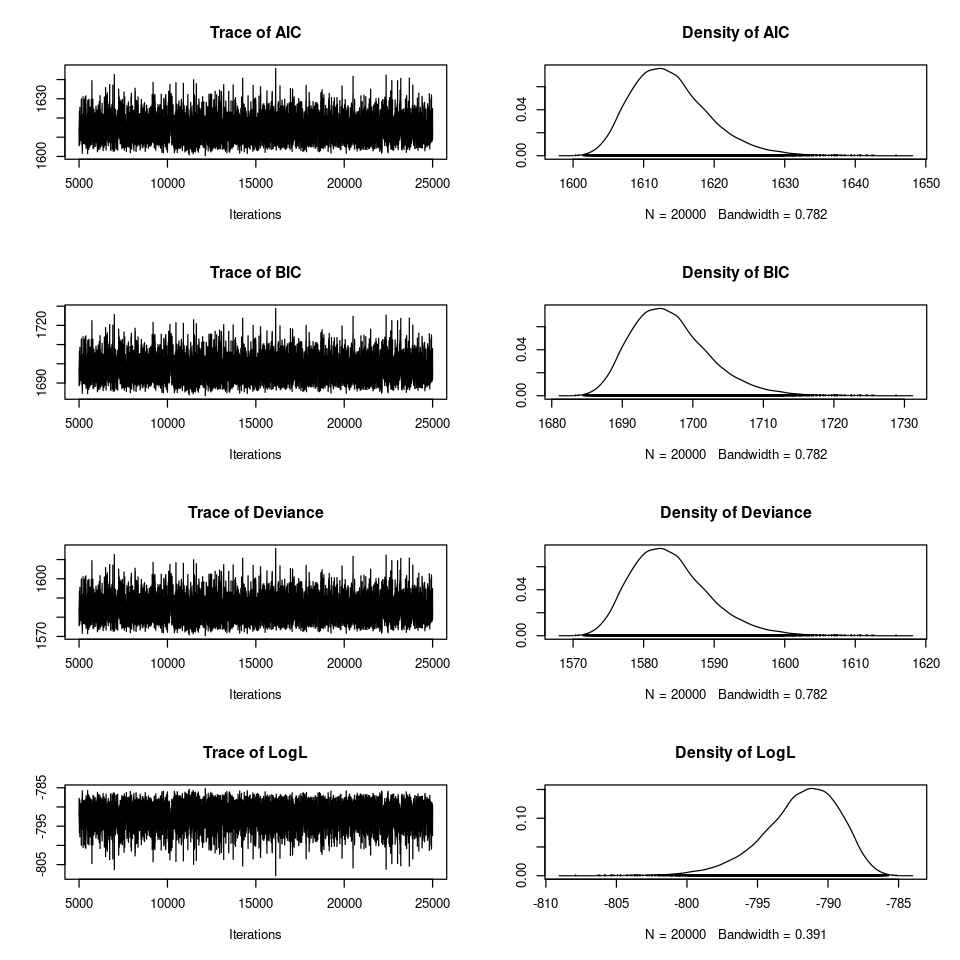

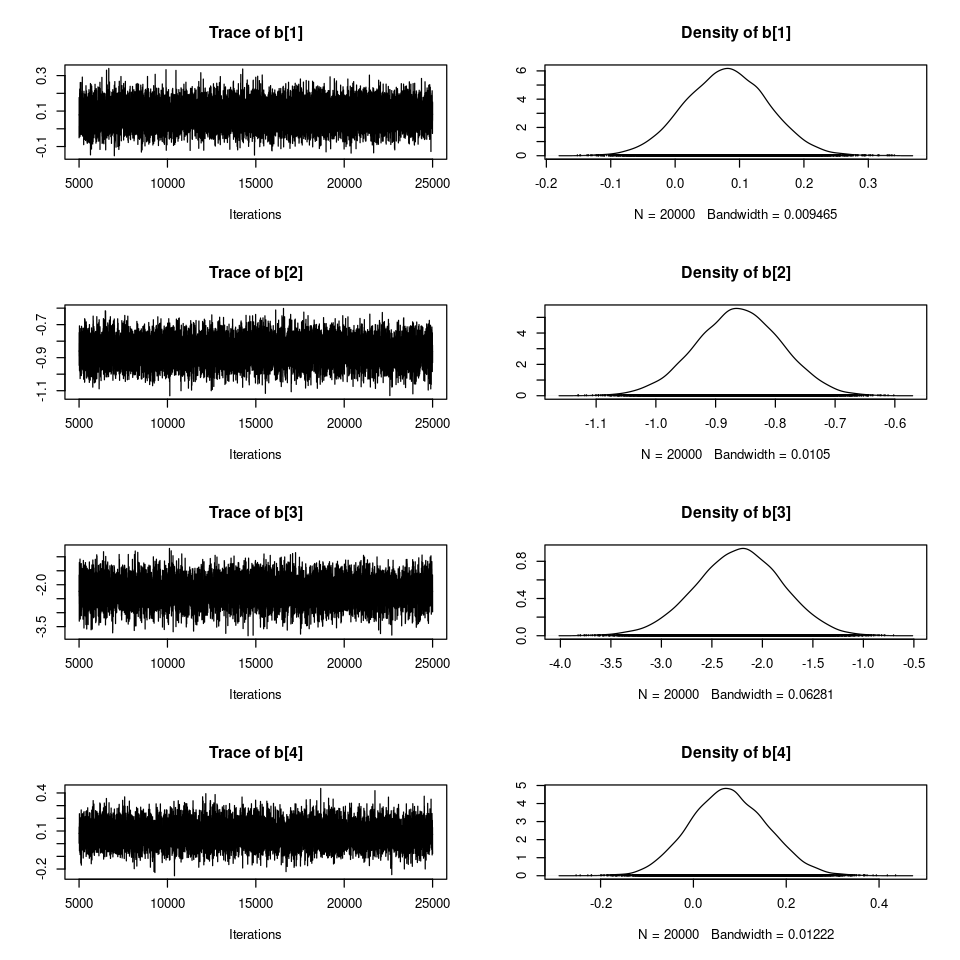

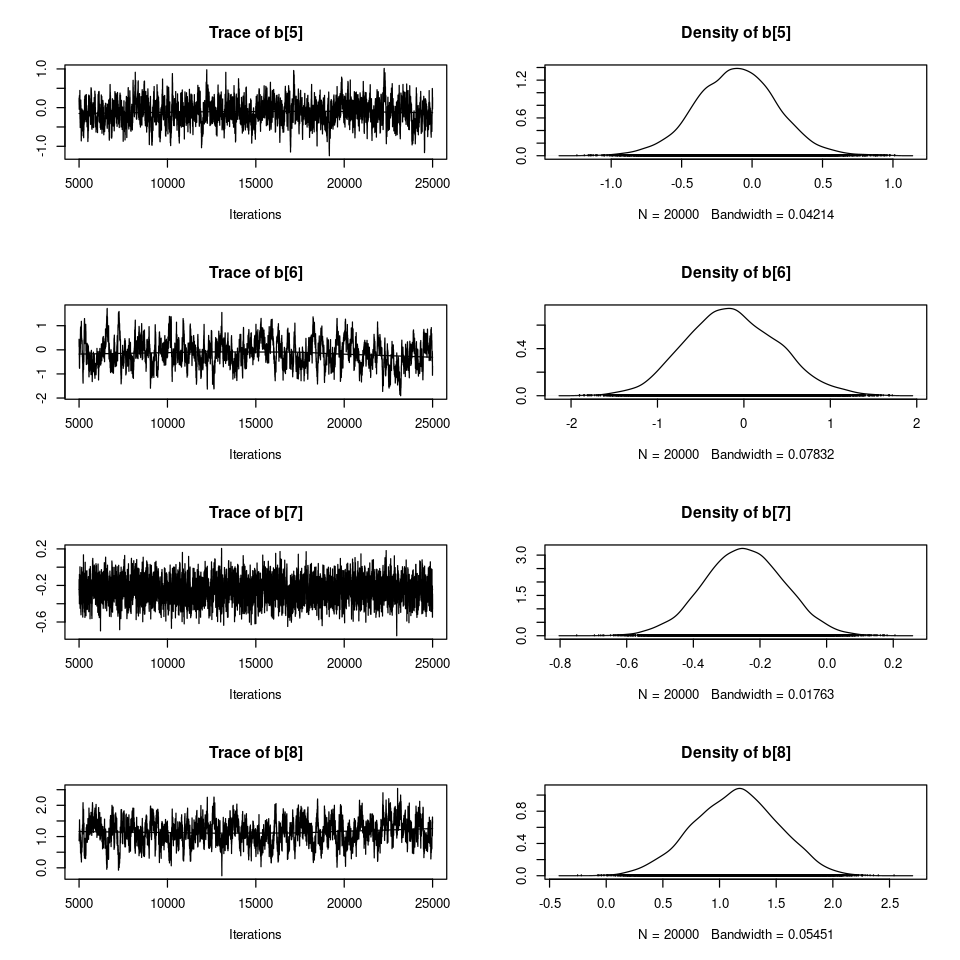

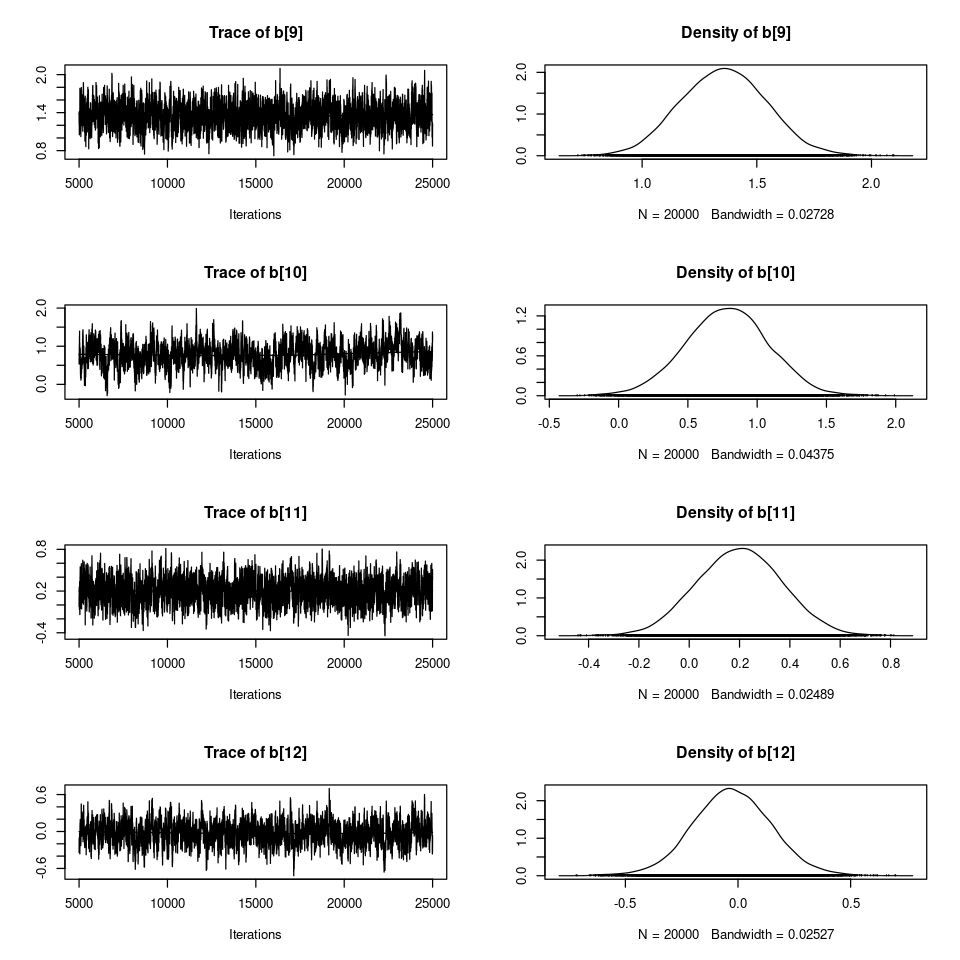

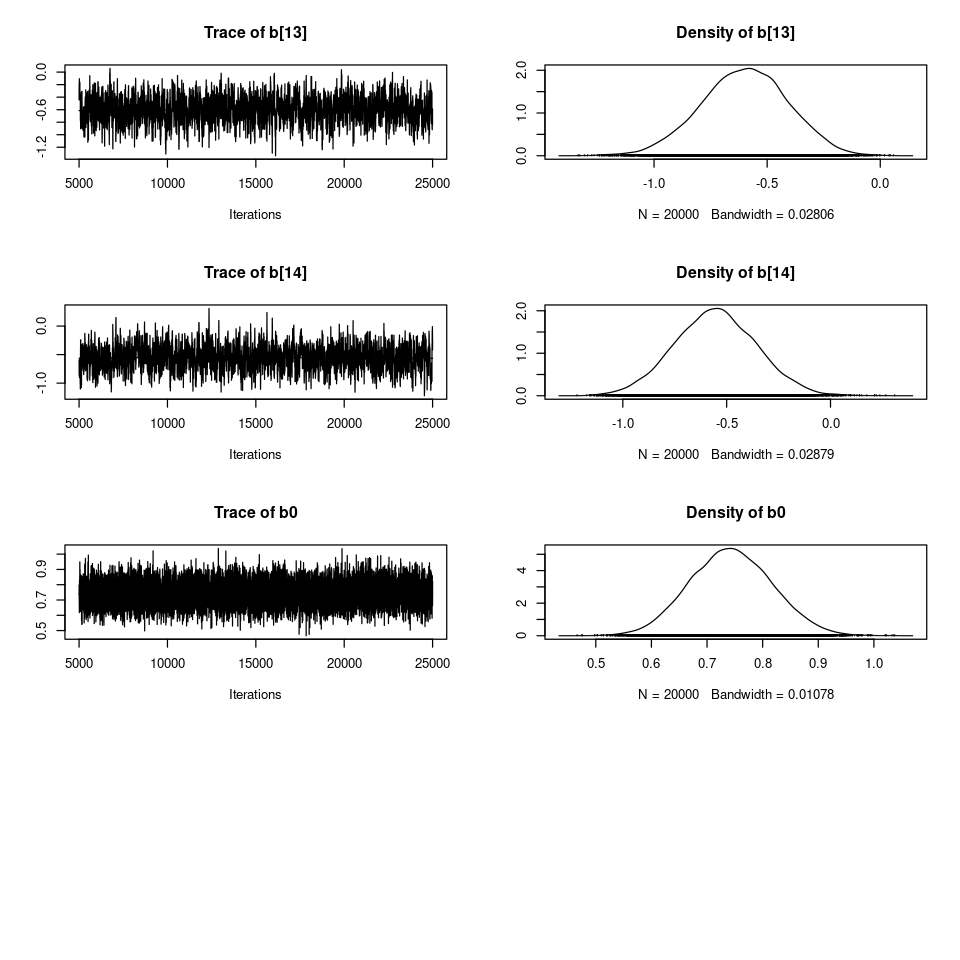

In [33]:
plot(sample.01)

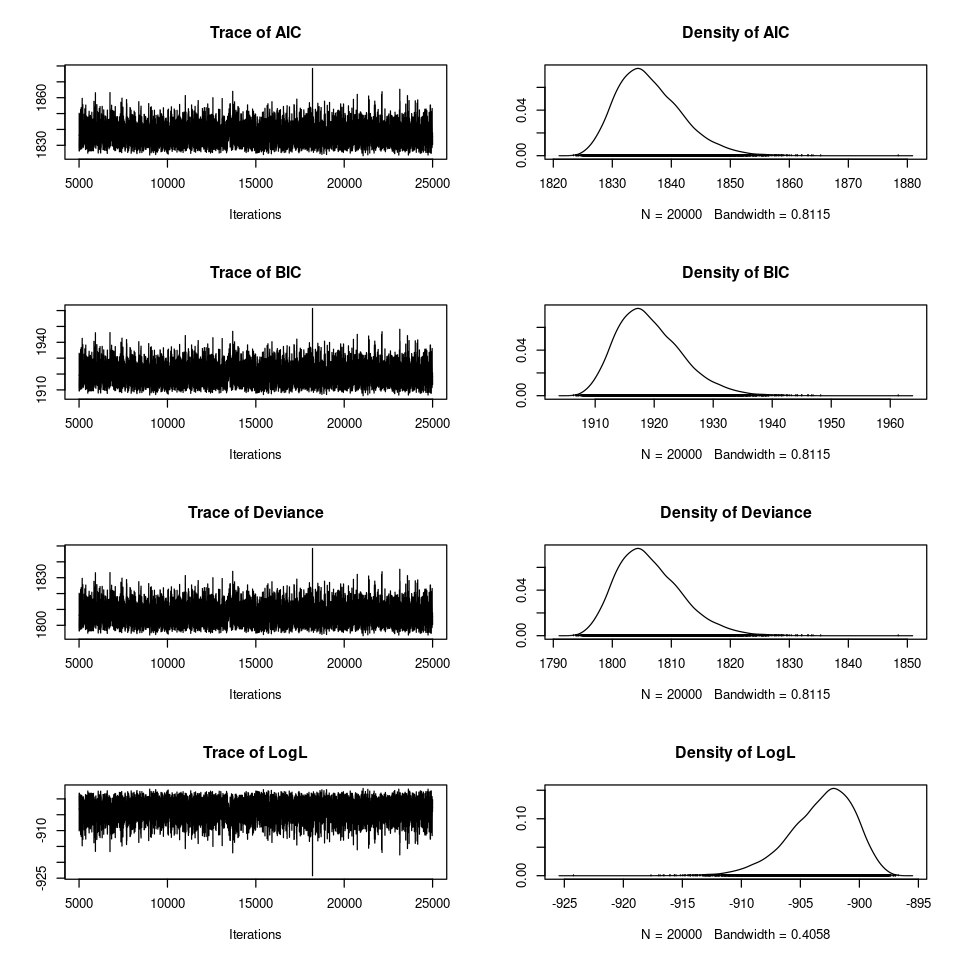

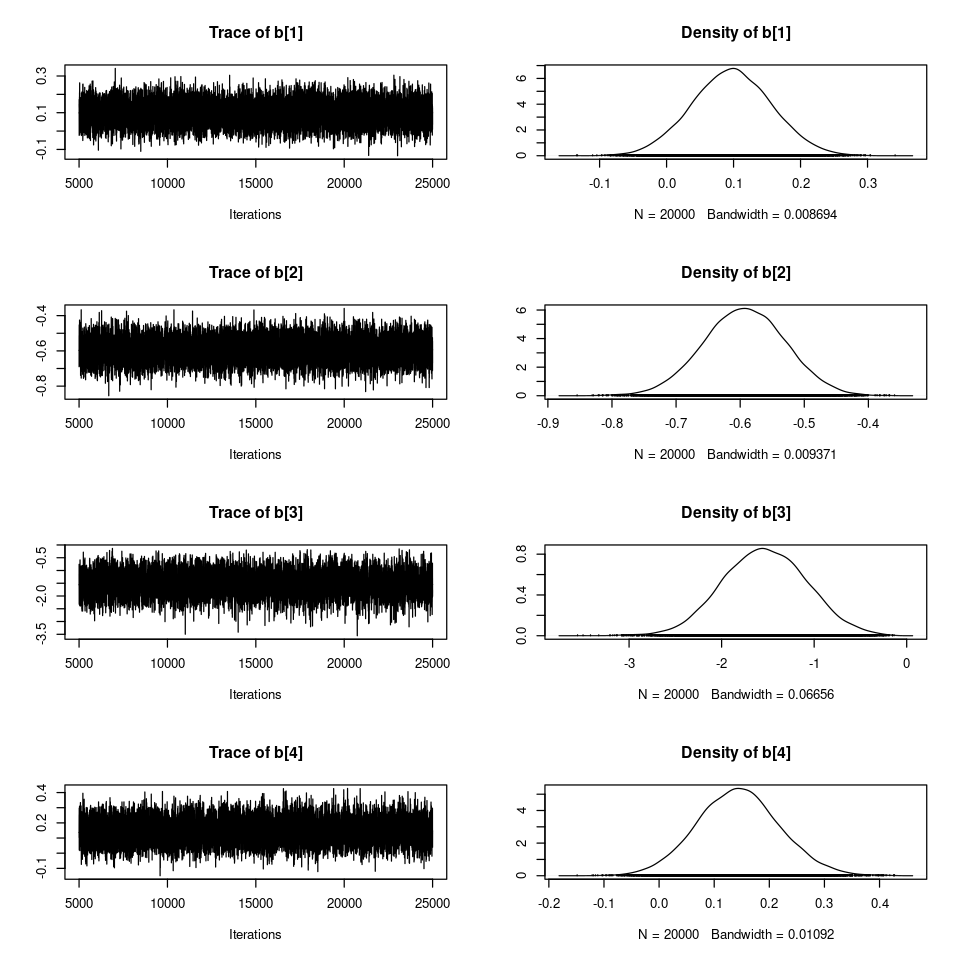

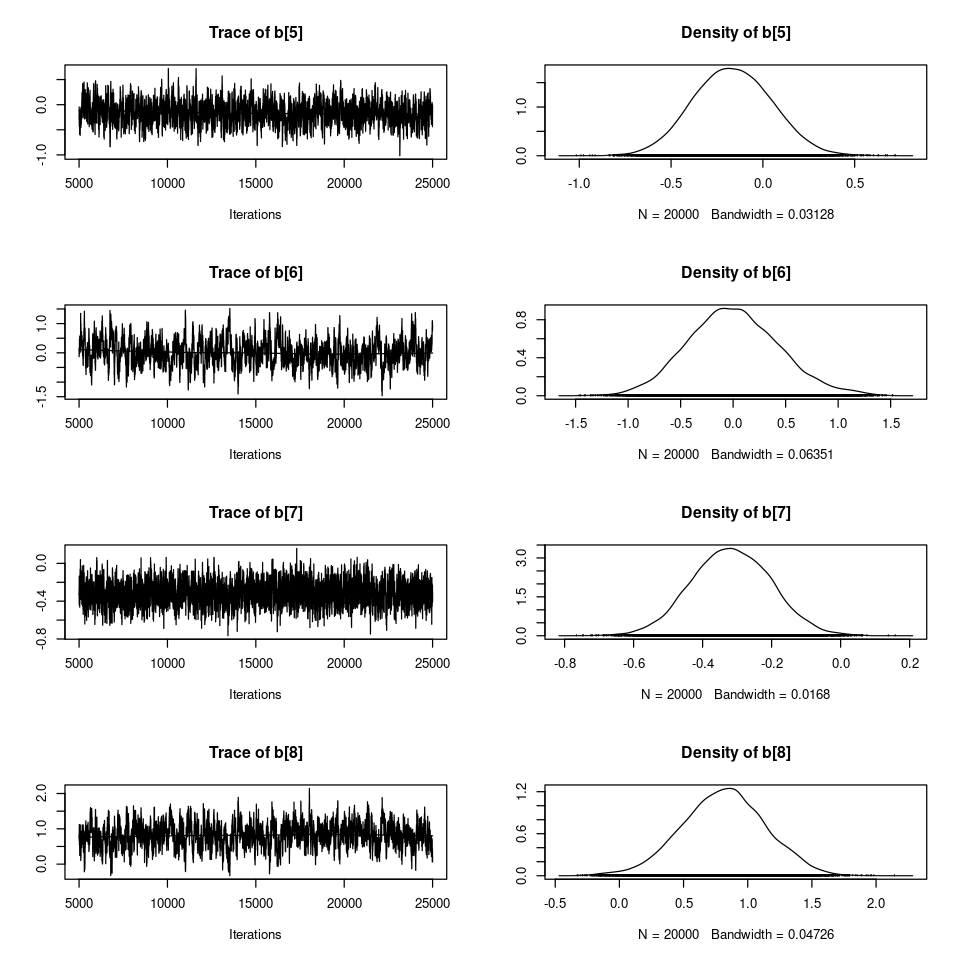

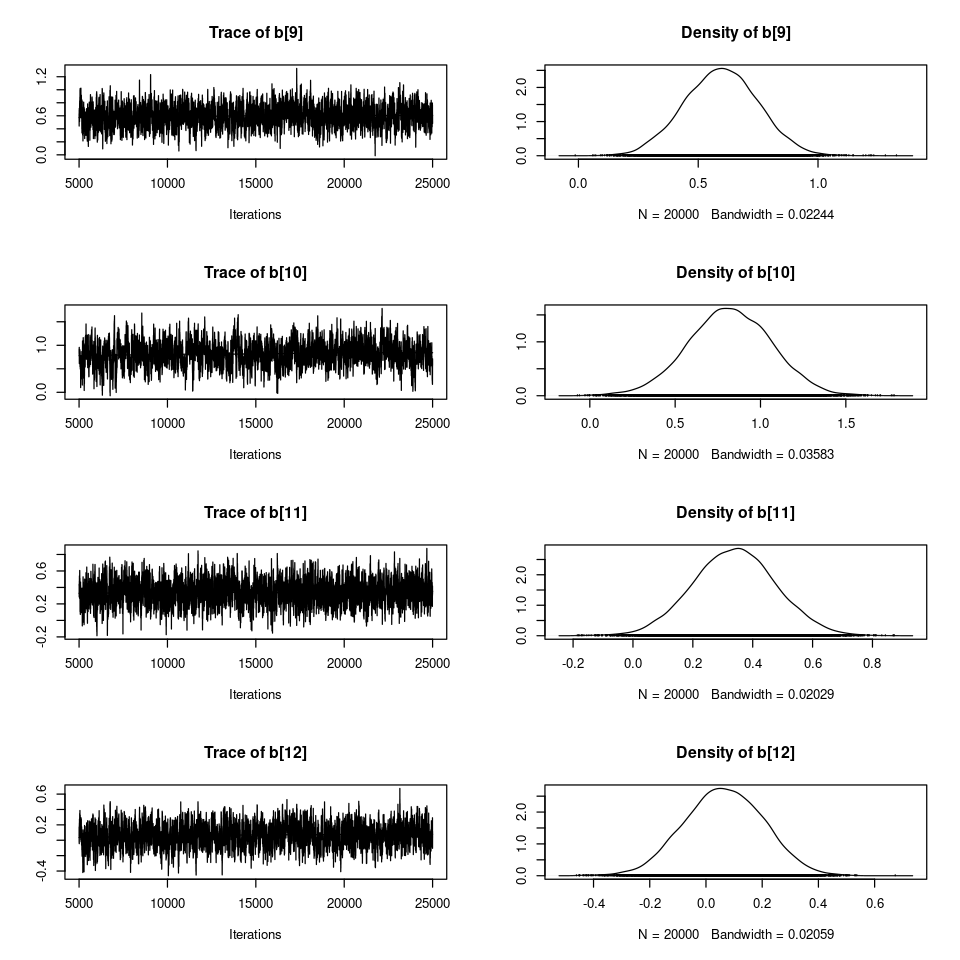

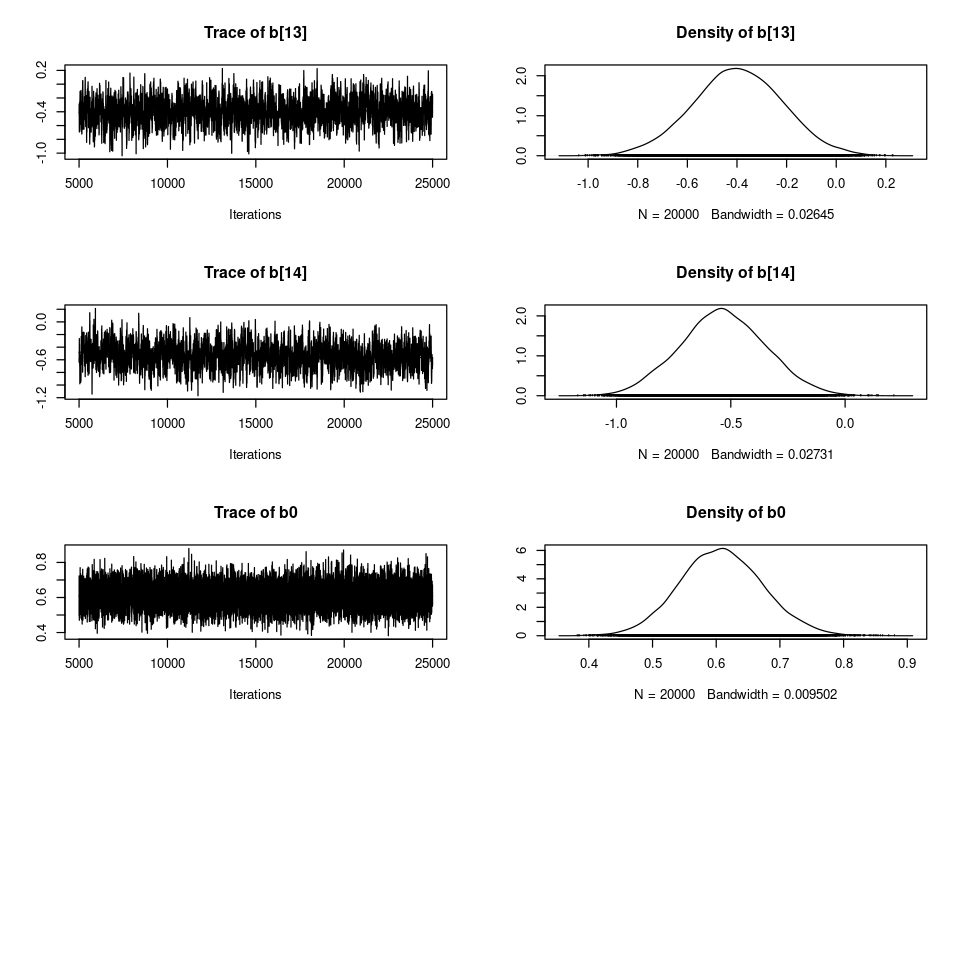

In [34]:
plot(sample.02)

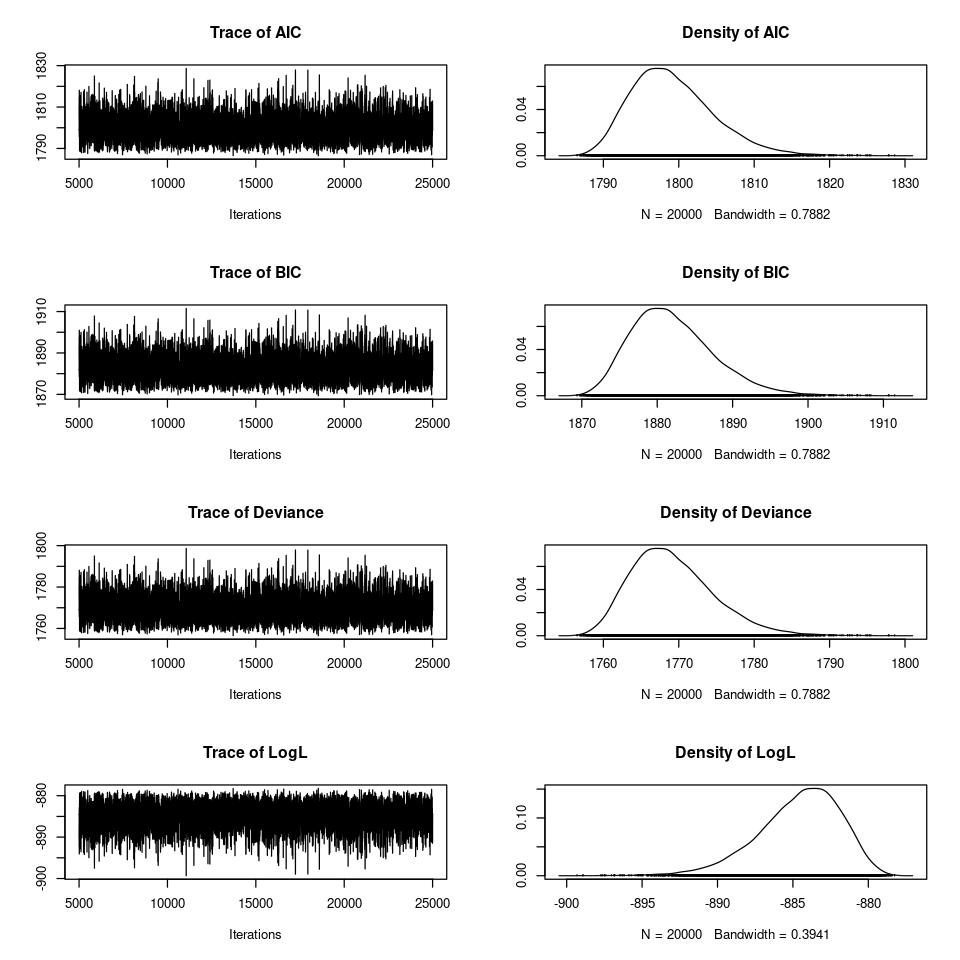

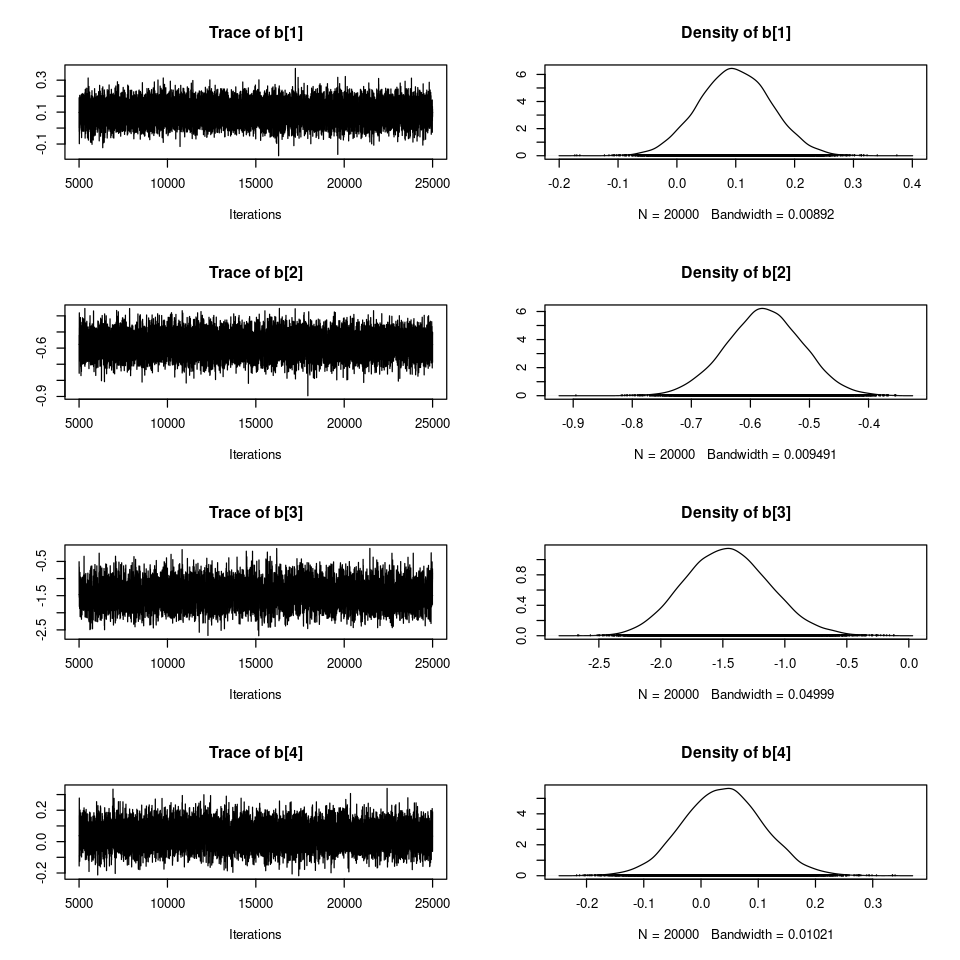

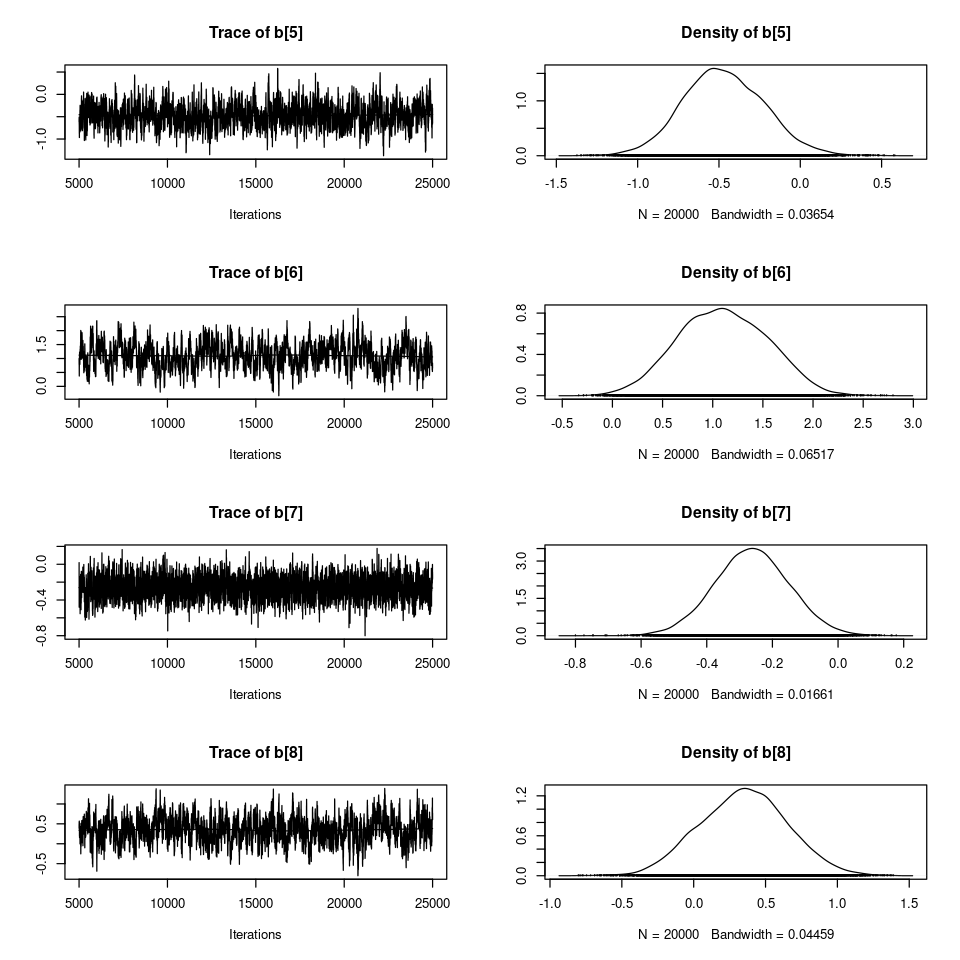

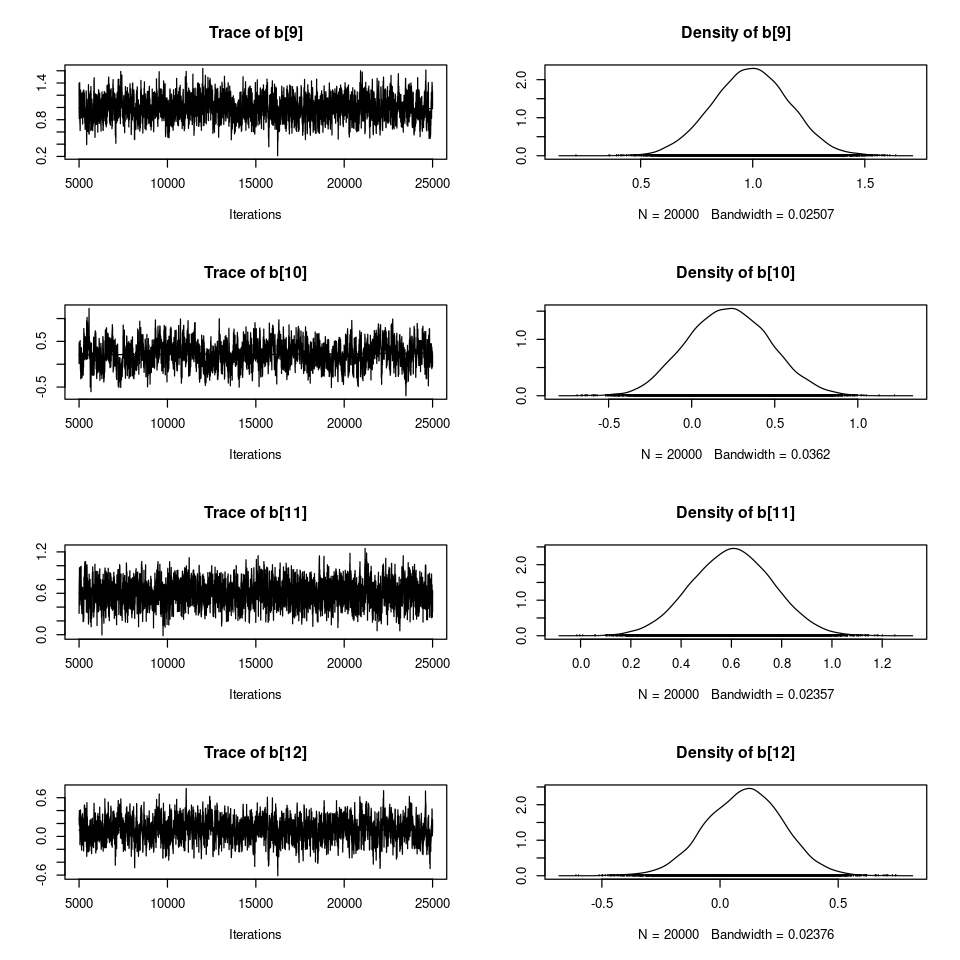

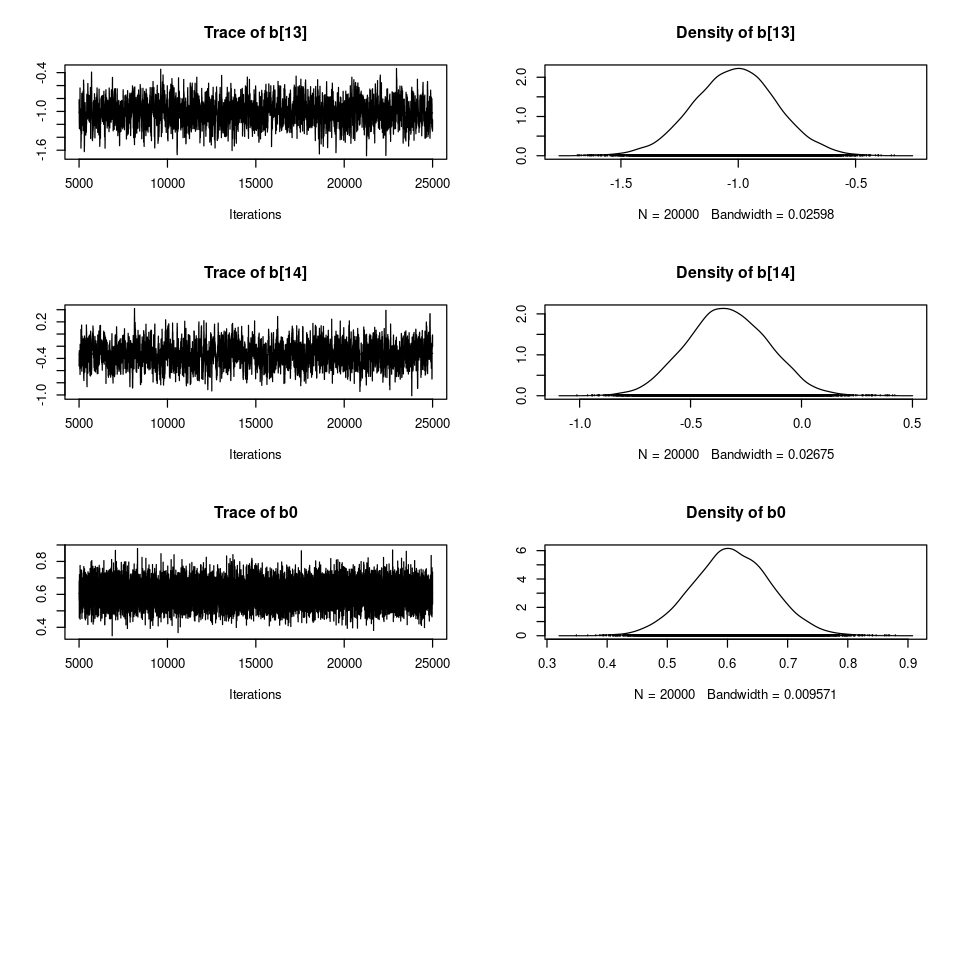

In [35]:
plot(sample.03)

The overall noisy traceplots show that posteriors are correctly sampled.

To check for consistency among initial subsamples, we look at the mean posterior values of the logistic parameters ($\beta_0$ and $\beta$) for each of them. As several times before, we define a function to do it:

In [36]:
logistic.params<-function(sample){
    #retrieve expected values of logistic regression params (the method in 
    # week12/GLM.01.Logistic.Challenger.ipynb does not work here because the 
    #JAGS object is different)
    stats<-summary(sample)$statistics
    a<-stats[19,1]
    b<-c()
    for (i in 5:18){
        b[i-4]<-stats[i,1]
        }
   return(list("b0"=a, "b"=b))
}

In [37]:
logistic.params(sample.01)
logistic.params(sample.02)
logistic.params(sample.03)

$b0
[1] 0.7433241

$b
 [1]  0.08017398 -0.86125607 -2.23091340  0.07624153 -0.11062519 -0.13225214
 [7] -0.24793654  1.14236057  1.35585690  0.78263791  0.20006107 -0.02661108
[13] -0.59992425 -0.55338484

$b0
[1] 0.6084825

$b
 [1]  0.097456450 -0.593445582 -1.534104551  0.144258138 -0.164815593
 [6]  0.007275571 -0.316643485  0.812389637  0.596183667  0.820774504
[11]  0.339209316  0.064048609 -0.396547833 -0.534727165

$b0
[1] 0.607337

$b
 [1]  0.09827787 -0.57652789 -1.46545560  0.03881214 -0.46938852  1.10262739
 [7] -0.26266966  0.34751219  0.99255835  0.22195013  0.60378181  0.10393205
[13] -1.01340652 -0.33339515

In [38]:
colnames(x0.01)

[1] "B_OWNPV_CHI2"        "B_IPCHI2_OWNPV"      "B_FDCHI2_OWNPV"     
 [4] "B_DIRA_OWNPV"        "B_PT"                "Kst_892_0_IP_OWNPV" 
 [7] "Kst_892_0_cosThetaH" "Kplus_IP_OWNPV"      "Kplus_P"            
[10] "piminus_IP_OWNPV"    "piminus_P"           "gamma_PT"           
[13] "piminus_ETA"         "Kplus_ETA"

The posterior means are less consistent across subsamples than in the random case, which is puzzling considering an important fraction of instances is obtained with the same targetted criterion for each subsample. Although this result may seem unsatisfactory, note that taking a greater subsample size would yield an unreasonable execution time for the notebook.

Another surprise is that **B_DIRA_OWNPV** is no longer supressed in all subsamples, which seems a negative result considering we had established it is uninformative.

### 2.2. Evaluation

To evaluate the model, we consider the train and test deviance, AIC and BIC. Since in this case we are applying Bayesian inference to a classification problem, we also compute the area under de ROC curve, which has the advantage over the latter that it is bounded and has absolute meaning (whereas deviation, AIC and BIC increase indefinitely with the size of the dataset used). Having established at the beginning of the notebook that we are mostly interested in true positives, we also look at recall (a.k.a. sensitivity, the fraction of total positives predicted as such): although we will show the other metrics for completeness, we will concentrate on AUC and recall, the latter computed for the optimal operating point of the ROC curve.

Note that for the test we use all samples not included in the corresponding 2000 train subsample, so **we test with about 210 000 samples** each time. We do this to put to use all available information, and we can afford to do so at test because we are just evaluating the logistic function (what took so long at train was the MCMC sampling).

Since, once again, we wil do this several times, we define a function to compute and print all relevant evaluation metrics. In the case of the train phase, we also print the deviance, AIC and BIC computed by JAGS, for reference.

In [39]:
evaluate<-function(sample, x, y, phase, threshold=NULL){
    n<-dim(x)[1]
    n.pars<-dim(x)[2]+1 # includes intercept
    
    #retrieve expected values of logistic regression params (the method in 
    # week12/GLM.01.Logistic.Challenger.ipynb does not work here because the JAGS object is different)
    stats<-summary(sample)$statistics
    a<-stats[19,1]
    b<-c()
    for (i in 5:18){
        b[i-4]<-stats[i,1]
        }
    #probabilities
    eta.bar<-as.numeric(a+b%*%t(x))
    p.bar<-1/(1+exp(-eta.bar))
    #log-likelihood
    logL.hat<-sum(y * log(p.bar) + (1 - y) * log(1 - p.bar))
    #AUC
    roc_obj <- roc(y, p.bar)
    AUC.hat<-auc(roc_obj)
    cat("\n", phase,"AUC:", round(AUC.hat,4)) 
    #deviance
    D.hat<- -2*logL.hat
    cat("\n", phase,"Deviance:", round(D.hat,4))  
    #AIC
    AIC.hat<-D.hat+2*n.pars
    cat("\n", phase,"AIC:", round(AIC.hat,4))  
    #BIC
    BIC.hat<-D.hat+log(n)*n.pars
    cat("\n", phase,"BIC:", round(BIC.hat,4))  
    #if training phase, print JAGS quantities as well for comparison
    if (phase=="train"){
        aic<-stats[1,1]
        bic<-stats[2,1]
        dev<-stats[3,1]
        cat("\n JAGS Deviance:", round(dev,4))  
        cat("\n JAGS AIC:", round(aic,4))  
        cat("\n JAGS BIC:", round(bic,4))   
        #compute threshold and recall/sensitivity for best operating point
        #in train ROC curve, also plotting the curve
        rc <- ROC(test=p.bar, stat = as.logical(y), plot="ROC", main="Train ROC curve") 
        opt <- which.max(rowSums(rc$res[, c("sens", "spec")]))
        # optimal cut-off point and corresponding recall
        threshold = as.numeric(names(opt))
        recall<-rc$res$sens[opt]
        cat("\n", phase, "recall/sensitivity", round(recall, 4))
        return(threshold)
        } else{
        # for true positives, y=1 and p.bar>threshold, so y+p.bar>1+threshold
        check<-y+p.bar 
        true.p<-0
        total.p<-sum(y)
        for (num in check){
            if (num >= (1+threshold)){
            true.p<-true.p+1    
            }
        }
        #print test recall
        recall<-true.p/total.p
        cat("\n", phase, "recall/sensitivity", round(recall, 4))
            
        }
    
    }

Having our function, we call it for the result obtained for each original subsample:

Setting levels: control = 0, case = 1

Setting direction: controls < cases




 train AUC: 0.8818
 train Deviance: 1568.77
 train AIC: 1598.77
 train BIC: 1681.8
 JAGS Deviance: 1583.823
 JAGS AIC: 1613.823
 JAGS BIC: 1696.853
 train recall/sensitivity 0.8557

Setting levels: control = 0, case = 1

Setting direction: controls < cases




 test AUC: 0.7848
 test Deviance: 342976
 test AIC: 343006
 test BIC: 343159.9
 test recall/sensitivity 0.9006

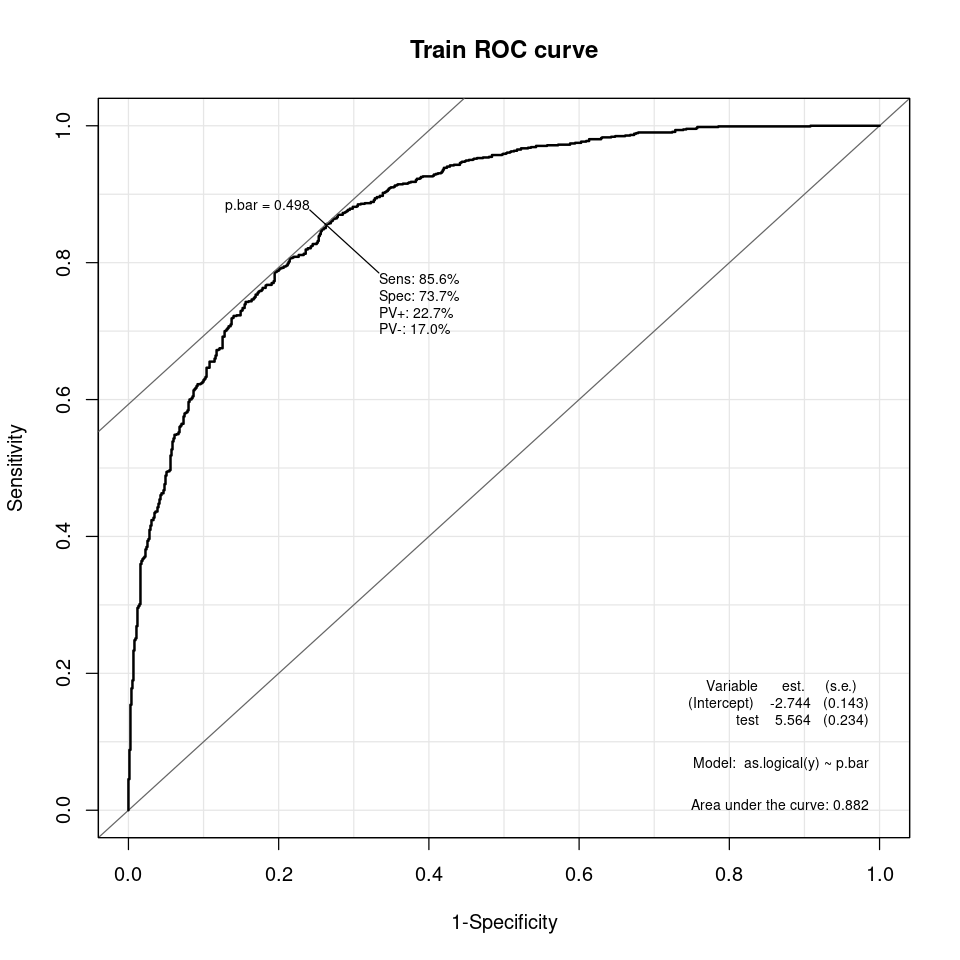

In [40]:
#evaluate train
thr<-evaluate(sample.01, x0.01, y.01, phase="train")
# evaluate test
xt<-model.matrix(Response~.,test.01)[,-1] #[,-1] to remove intercept intrduced by model.matrix
xt<-standardise(xt)
yt<-test.01$Response
evaluate(sample.01, xt, yt, phase="test", threshold = thr)

Setting levels: control = 0, case = 1

Setting direction: controls < cases




 train AUC: 0.8413
 train Deviance: 1791.326
 train AIC: 1821.326
 train BIC: 1904.227
 JAGS Deviance: 1806.401
 JAGS AIC: 1836.401
 JAGS BIC: 1919.302
 train recall/sensitivity 0.8043

Setting levels: control = 0, case = 1

Setting direction: controls < cases




 test AUC: 0.7746
 test Deviance: 319196.1
 test AIC: 319226.1
 test BIC: 319379.9
 test recall/sensitivity 0.8582

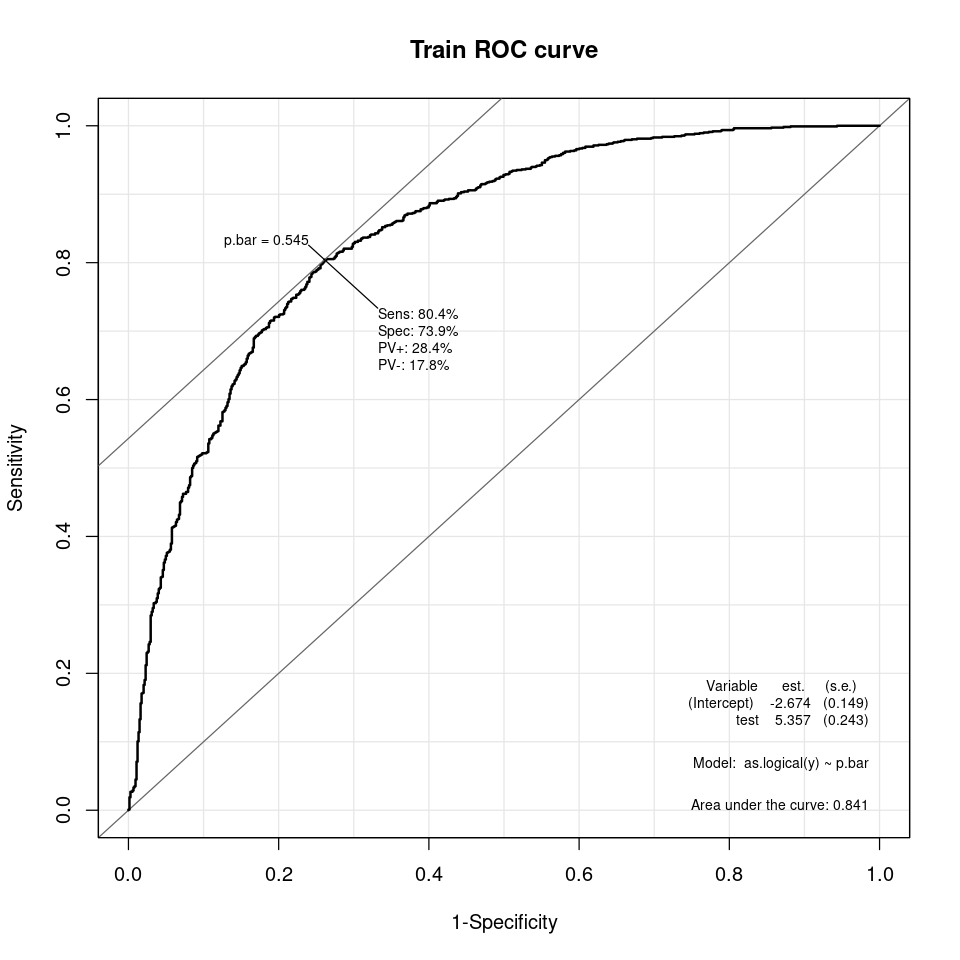

In [41]:
thr<-evaluate(sample.02, x0.02, y.02, phase="train")

xt<-model.matrix(Response~.,test.02)[,-1] #[,-1] to remove intercept intrduced by model.matrix
xt<-standardise(xt)
yt<-test.02$Response
evaluate(sample.02, xt, yt, phase="test", threshold = thr)

Setting levels: control = 0, case = 1

Setting direction: controls < cases




 train AUC: 0.8523
 train Deviance: 1754.156
 train AIC: 1784.156
 train BIC: 1867.016
 JAGS Deviance: 1769.193
 JAGS AIC: 1799.193
 JAGS BIC: 1882.053
 train recall/sensitivity 0.7662

Setting levels: control = 0, case = 1

Setting direction: controls < cases




 test AUC: 0.7745
 test Deviance: 320820.4
 test AIC: 320850.4
 test BIC: 321004.3
 test recall/sensitivity 0.7934

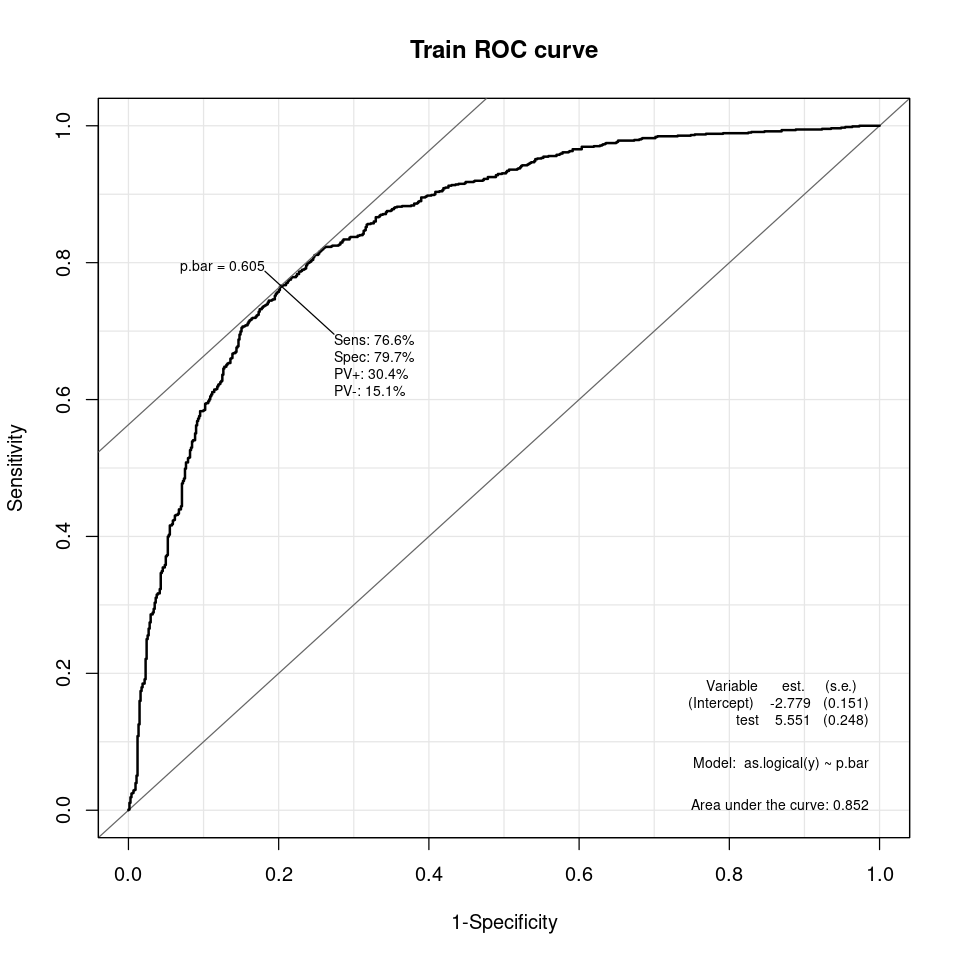

In [42]:
thr<-evaluate(sample.03, x0.03, y.03, phase="train")

xt<-model.matrix(Response~.,test.03)[,-1] #[,-1] to remove intercept intrduced by model.matrix
xt<-standardise(xt)
yt<-test.03$Response
evaluate(sample.03, xt, yt, phase="test", threshold = thr)

We get similar test AUCs across subsamples (0.77 or 0.78), while test recall varies from 0.78 to 0.90. There is also an apparent overfitting in AUC, the train values being greater than the test ones, although such is not the case for recall.

Although results seem better for recall (the measure of most interest) and the train size is a bit lower than in the random case (1800 vs 2000), we think this a misleadin result. Indeed, when trying before with the three greater subsamples (with size $>2000$) in *data/*, we obtained test AUCs of 0.77 and recalls from 0.77 to 0.80: slightly worse than in the random case.

This, coupled to the variability shown by the logistic parameters, seems to suggest that our RTR method, by repeatedly forcing the OSS through random removal, is not actually enhancing the information in the final subsamples, but *distorting* the boundary in an unpredictable way. Another possibility is that the logistic regression, being linear, is too simple a model to capture the real boundary, hence behaving strangely when fed a higher-fidelity subsample, but this seems unlikely. 

Regarding the remarkably good test recall obtained above, we believe it may be the consequence of a greater proportion of signal w.r.t. to the random case (60% vs 50%), and the fact that it does not show with the greater subsamples may be explained by the fluctuating behaviour of the RTR. This is interesting, because it would suggest there is more to imbalance problems than just seeking perfect balance: not only may there be an asymmetric distribution of useful information across classes in a given dataset, but also one may be interested in having a greater proportion of the signal of interest to enhance its identification beyond the reach of perfect balance.

## 3. Conclusion

The RTR with OSS seems to have failed, and the above results point to an intrinsic flaw of the RTR approach. However, we can still try it with another targetting method to further ponder such a possibility: that is what we do in **CERN-NcrSamples-Logistic-JAGS**.